# Reference genome test (Ensemble 93 vs 98)

# Reference genome testing - Preprocessing

<div class="alert alert-warning">

**What these notebooks do**
    
The following collection of notebooks compares data aligned to Ensemble 93 and 98. For this test, snRNA data subsets from of Hey et. al. (g003) and Zhong et. al. (CNR0176487) were both aligned to the two reference genomes with Cell Ranger v6.1 without mapping to intronic regions. This test aims to identify the disparity created by the different reference genomes. 

The collection of notebooks contains four main sections: 1) Preprocessing, 2) Filtering, 3) Normalization, 4) Merging
    
<br>   
    
v**What the first section (Preprocessing) does**
    
This section takes the aligned h5 files and shapes the data with annotations and quality control metrics. This additional information will be used to filter the data and prepare it for subsequent processing. For each h5 file a <sample_name>_preprocessed.h5ad file will be made which contain all necessary annotation for subsequent filtering. The section contains the following important subsections:

* Doublet detection <br>
* Adding quality metrics and mitochondrial gene removal<br>
  
    
<br>   
    
**What the second section (Filtering) does**

This section visualizes various quality control metric values and filters the data based on a threshold made on the observations/domain knowledge. The section contains the following important subsections:

* Doublet filtering <br>
* UMIs and gene counts filtering <br>
    
<br> 
    
**What the third section (Normalization) does**
    
This section normalizes the data based on sequencing depth and gene length so the cells are comparable. Subsequently dimensional reduction and clustering are performed to visualize samples separately. The section contains the following important subsections:

* Normalization <br>
* Dimensional reduction <br>
* Marker genes and property annotation visualizations <br>
    
<br>
    
**What the fourth section (Merging) does**
    
This section merges the different datasets and visualizes the merged data. The section contains the following important subsections:

* Merging <br>
* Alignment parameter visualization <br>
</div>  



### Loading libraries
Using sc2_seurat environment, importing packages and setting parameters.

In [1]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/hpc/hers_basak/bin/miniconda3/envs/sc2_seurat/bin/python
3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:40:17) 
[GCC 9.4.0]
sys.version_info(major=3, minor=9, micro=9, releaselevel='final', serial=0)


In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))#embed HTML within IPython notebook and make containers 90% of screen
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import os
import matplotlib.pyplot as plt

%matplotlib inline
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white') #figure resolution and background color

# This is used
# os.path.join('data/'+object_names[i][6:10]+'_preprocessed.h5ad')
#sc.logging.print_versions()

### Cell Ranger files

In [3]:
#Hey
hey_93='/hpc/hers_basak/rnaseq_data/Basaklab/jjiang/outputs/count_files/mus_mus/hey/ref93_cellrangerv6/outs/filtered_feature_bc_matrix.h5'
hey_98='/hpc/hers_basak/rnaseq_data/Basaklab/jjiang/outputs/count_files/mus_mus/hey/ref98_cellrangerv6/outs/filtered_feature_bc_matrix.h5'

#Zhong
zhong_93='/hpc/hers_basak/rnaseq_data/Basaklab/jjiang/outputs/count_files/mus_mus/zhong_2021/ref93_cellrangerv6/outs/filtered_feature_bc_matrix.h5'
zhong_98='/hpc/hers_basak/rnaseq_data/Basaklab/jjiang/outputs/count_files/mus_mus/zhong_2021/ref98_cellrangerv6/outs/filtered_feature_bc_matrix.h5'


In [4]:
#set data path
os.chdir('/home/hers_basak/jjiang/jack/outputs/deliverables/0_reference_genome_testing')

In [5]:
os.getcwd()

'/hpc/hers_basak/rnaseq_data/Basaklab/jjiang/outputs/deliverables/0_reference_genome_testing'

## Load data
The .h5 files from 10x that we are using contains feature and barcode information. Empty barcodes are already filtered out from these files.

In [6]:
files = [hey_93,hey_98,zhong_93,zhong_98]
names = ['hey_93','hey_98','zhong_93','zhong_98'] #used for making variable names

numberobj = len(names)

object_names = list()

#locals() returns dictionary with all local variables and symbols
for i in range(numberobj):
    locals()["adata"+"_"+names[i]] = sc.read_10x_h5(files[i])
    locals()["adata"+"_"+names[i]].var_names_make_unique()
    print("adata"+"_"+names[i],"is loaded")
    
    object_names.append("adata"+"_"+names[i]) # make list of objects for later

/hpc/hers_basak/bin/miniconda3/envs/sc2_seurat/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


adata_hey_93 is loaded


/hpc/hers_basak/bin/miniconda3/envs/sc2_seurat/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


adata_hey_98 is loaded


/hpc/hers_basak/bin/miniconda3/envs/sc2_seurat/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


adata_zhong_93 is loaded
adata_zhong_98 is loaded


/hpc/hers_basak/bin/miniconda3/envs/sc2_seurat/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [7]:
adata_hey_98 #gene annotation

AnnData object with n_obs × n_vars = 4827 × 32285
    var: 'gene_ids', 'feature_types', 'genome'

## Basic Preprocessing
### Doublet detection using scrublet
Doublets are droplets that captures two cells, which will lead to inconsistencies. So we need to detect and remove them. First we will annotate the objects with metadata.

https://github.com/swolock/scrublet
https://www.sciencedirect.com/science/article/pii/S2405471218304745

Following the advice of Chromium (below), for 5200 cells recovered, ~4.04% doublets are to be expected (zhong). For 4800 recovered cells, ~3.74% is expected (hey).
> https://uofuhealth.utah.edu/huntsman/shared-resources/gba/htg/single-cell/genomics-10x.php


In [8]:
names

['hey_93', 'hey_98', 'zhong_93', 'zhong_98']

In [9]:
object_names

['adata_hey_93', 'adata_hey_98', 'adata_zhong_93', 'adata_zhong_98']

In [11]:
#manually adding metadata due to lack of metadata file
for i in range(numberobj):
    locals()[object_names[i]].obs['species'] = ['Mus musculus','Mus musculus','Mus musculus','Mus musculus'][i]
    #locals()[object_names[i]].obs['gender'] = [,'male','male'][i]
    #locals()[object_names[i]].obs['age'] = ['6 months','6 months'][i]
    locals()[object_names[i]].obs['cngb_sample_id'] = ['','','CNS0195744','CNS0195744'][i]
    locals()[object_names[i]].obs['sample_group'] = ['g003','g003','CNR0176487','CNR0176487'][i]
    locals()[object_names[i]].obs['atlas'] = ['hey','hey','zhong','zhong'][i]
    locals()[object_names[i]].obs['reference'] = ['ensemble_93', 'ensemble_98','ensemble_93', 'ensemble_98'][i]
    
#viewing object annotations
for i in range(numberobj):
    print(locals()[object_names[i]].shape)
    

thr = 0.20
expected_doublet_rates = [0.0374,0.0374,0.0404,0.0404] 
for i in range(numberobj):
    #predicts doublets and adds a score to objects
    sc.external.pp.scrublet(locals()[object_names[i]], expected_doublet_rate=expected_doublet_rates[i], stdev_doublet_rate=0.02, 
                            synthetic_doublet_umi_subsampling=1.0, knn_dist_metric='euclidean', normalize_variance=True, 
                            log_transform=False, mean_center=True, n_prin_comps=30, use_approx_neighbors=True, 
                            get_doublet_neighbor_parents=False, n_neighbors=None, threshold=thr, verbose=True, copy=False, random_state=0)
    #plot histogram of doublet scores(doesnt work in loop)
    sc.external.pl.scrublet_score_distribution(locals()[object_names[i]], scale_hist_obs='log', scale_hist_sim='linear', figsize=(8, 3),
                                               show=True,return_fig=True)


(4781, 31053)
(4827, 32285)
(5210, 31053)
(5177, 32285)


/hpc/hers_basak/bin/miniconda3/envs/sc2_seurat/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Detected doublet rate = 2.8%
Estimated detectable doublet fraction = 53.4%
Overall doublet rate:
	Expected   = 3.7%
	Estimated  = 5.2%


/hpc/hers_basak/bin/miniconda3/envs/sc2_seurat/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Detected doublet rate = 2.7%
Estimated detectable doublet fraction = 53.8%
Overall doublet rate:
	Expected   = 3.7%
	Estimated  = 4.9%


/hpc/hers_basak/bin/miniconda3/envs/sc2_seurat/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Detected doublet rate = 3.8%
Estimated detectable doublet fraction = 20.9%
Overall doublet rate:
	Expected   = 4.0%
	Estimated  = 18.3%


/hpc/hers_basak/bin/miniconda3/envs/sc2_seurat/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Detected doublet rate = 4.0%
Estimated detectable doublet fraction = 21.7%
Overall doublet rate:
	Expected   = 4.0%
	Estimated  = 18.2%


Check how many cells are higher than the threshold

In [12]:
for i in range(numberobj):
    print(names[i],'\n',locals()[object_names[i]].obs['predicted_doublet'].value_counts(),'\n')

hey_93 
 False    4649
True      132
Name: predicted_doublet, dtype: int64 

hey_98 
 False    4699
True      128
Name: predicted_doublet, dtype: int64 

zhong_93 
 False    5011
True      199
Name: predicted_doublet, dtype: int64 

zhong_98 
 False    4972
True      205
Name: predicted_doublet, dtype: int64 



### Scrublet simulation plot

In [13]:
for i in range(numberobj):
    print(names[i])
    sc.external.pl.scrublet_score_distribution(locals()[object_names[i]], scale_hist_obs='log', scale_hist_sim='linear', figsize=(8, 3),show=True,return_fig=True)

hey_93
hey_98
zhong_93
zhong_98


### Add QC and get rid of mitochondrial genes

In [14]:
adata_hey_98


AnnData object with n_obs × n_vars = 4827 × 32285
    obs: 'species', 'cngb_sample_id', 'sample_group', 'atlas', 'reference', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'scrublet'

<b> check this: sc.pp.calculate_qc_metrics() </b> <br>
expr_type: kind of values in X (str)<br>
var_type: kind of variables (str)<br>
qc_vars: keys for variables you want to control (collection of str)<br>
percent_top: proportions of top genes to cover, for cummulative proportion of counts (collection of int)<br>
layer: alternative layers for expression data (str)<br>
use_raw: use adata.raw.X for expression values (bool)<br>
inplace: place metrics in adata (bool)<br>
log1p: compute log1p transformed annotations, for very small values (bool)<br>
<br>
<b> return features obs </b> <br>
n_genes_by_counts: The number of genes with at least 1 count in a cell. <br>
total_counts: Total number of counts for a cell. <br>
total_counts_mt:Total number of mt gene counts for a cell. <br>
pct_counts_mt: Proportion (%) of total counts for a cell which are mitochondrial. <br> 
n_genes: Number of genes with a positive count. <br>
total_counts_ribo: Total number of ribosomal counts for a cell. <br>
pct_counts_ribo: Proportion of total counts for a cell which are ribosomal.

In [15]:
import numpy as np

for i in range(numberobj):
    #add mt variable annotation indicating if a gene is ribosomal or not (bool)
    if locals()[object_names[i]].obs['species'][0] == 'Homo sapiens':
        locals()[object_names[i]].var['mt'] = locals()[object_names[i]].var_names.str.startswith('MT-')
    elif locals()[object_names[i]].obs['species'][0] == 'Mus musculus':
        locals()[object_names[i]].var['mt'] = locals()[object_names[i]].var_names.str.startswith('mt-') 
        
    if locals()[object_names[i]].obs['species'][0] == 'Homo sapien':
        locals()[object_names[i]].var['ribo'] = locals()[object_names[i]].var_names.str.startswith('RP')
    elif locals()[object_names[i]].obs['species'][0] == 'Mus musculus':
        locals()[object_names[i]].var['ribo'] = locals()[object_names[i]].var_names.str.startswith('Rp')
    
    sc.pp.calculate_qc_metrics(locals()[object_names[i]], expr_type='counts', var_type='genes', qc_vars=('mt','ribo'), percent_top= (), layer= None, use_raw= False, inplace=True, log1p=True)
     
    locals()[object_names[i]].var_names_make_unique()
    sc.pp.filter_cells(locals()[object_names[i]], min_genes=1) #remove all cells with 0 genes
                 
    # The following is to solve a save issue. Probably because of the NA valies in ther 'predicted_doublet' slot
    locals()[object_names[i]].obs['predicted_doublet'] =  locals()[object_names[i]].obs['predicted_doublet'].astype('str')

    

Checking median number of mitochondrial genes, genes and UMIs per cell to have an idea of the quality of each run:

In [16]:
print("Median numbers before filtering mt genes")
for i in range(numberobj):
    print(
         object_names[i],'\n',"\tmito%:",np.median(locals()[object_names[i]].obs['pct_counts_mt']),'\n',"\tmedian genes/nuclei:",np.median(locals()[object_names[i]].obs['n_genes']),'\n', 
            "\tmedian reads/nuclei:",np.median(locals()[object_names[i]].obs['total_counts']),'\n',
           "\tmean genes/nuclei:",int(np.mean(locals()[object_names[i]].obs['n_genes'])),'\n',
         "\tmean reads/nuclei:",  int(np.mean(locals()[object_names[i]].obs['total_counts'])), '\n')
    

Median numbers before filtering mt genes
adata_hey_93 
 	mito%: 0.47664443 
 	median genes/nuclei: 921.0 
 	median reads/nuclei: 1422.0 
 	mean genes/nuclei: 1317 
 	mean reads/nuclei: 2298 

adata_hey_98 
 	mito%: 0.46430644 
 	median genes/nuclei: 939.0 
 	median reads/nuclei: 1435.0 
 	mean genes/nuclei: 1344 
 	mean reads/nuclei: 2347 

adata_zhong_93 
 	mito%: 0.6688963 
 	median genes/nuclei: 952.5 
 	median reads/nuclei: 1263.5 
 	mean genes/nuclei: 997 
 	mean reads/nuclei: 1373 

adata_zhong_98 
 	mito%: 0.64935064 
 	median genes/nuclei: 982.0 
 	median reads/nuclei: 1305.0 
 	mean genes/nuclei: 1029 
 	mean reads/nuclei: 1419 



In [17]:
print(adata_hey_98)
print(adata_hey_98.obs['total_counts'])
print(adata_hey_98.obs['pct_counts_mt'])

AnnData object with n_obs × n_vars = 4827 × 32285
    obs: 'species', 'cngb_sample_id', 'sample_group', 'atlas', 'reference', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'scrublet'
AAACCCAAGCAATTAG-1      537.0
AAACCCACAGGAGGAG-1    13701.0
AAACCCAGTACGGATG-1      713.0
AAACCCAGTCGTTATG-1      765.0
AAACCCATCTACGGTA-1      618.0
                       ...   
TTTGTTGAGTCGCCAC-1     4202.0
TTTGTTGCATTAGGCT-1     1254.0
TTTGTTGGTAACATAG-1     9437.0
TTTGTTGTCAAGCTGT-1     1055.0
TTTGTTGTCCGCACTT-1     1682.0
Name: total_counts, Length: 4827, dtype: float32
AAACCCAAGCAATTAG-1    0.744879
A

Filtering out mito genes to determine number of non mitochondrial genes:

In [18]:
for i in range(numberobj):
    #list all non mitochondrial genes for subsetting the columns
    if locals()[object_names[i]].obs['species'][0] == 'Homo sapien':
         non_mito_genes_list = [name for name in locals()[object_names[i]].var_names if not name.startswith('MT-')]
    elif locals()[object_names[i]].obs['species'][0] == 'Mus musculus':
        non_mito_genes_list = [name for name in locals()[object_names[i]].var_names if not name.startswith('mt-')]
    
    
    locals()[object_names[i]] = locals()[object_names[i]][:, non_mito_genes_list].copy()
    
    locals()[object_names[i]].obs['total_counts_mito'] =  locals()[object_names[i]].obs['total_counts']
    
    
    #recalculate the number of genes, because some cells only had mt gene counts
    sc.pp.filter_cells(locals()[object_names[i]], min_genes=1)

### Recalculate metrics (skip this because we recalculated total counts without mito genes above)
Note that the qc_vars=None because we want to keep the mt%."


In [19]:
for i in range(numberobj):
    sc.pp.calculate_qc_metrics(locals()[object_names[i]], expr_type='counts', var_type='genes', qc_vars=(), percent_top= (), layer= None, use_raw= False, inplace=True, log1p=True)
adata_hey_98
print(adata_hey_98.obs['total_counts'])
print(adata_hey_98.obs['pct_counts_mt'])

AAACCCAAGCAATTAG-1      533.0
AAACCCACAGGAGGAG-1    13641.0
AAACCCAGTACGGATG-1      710.0
AAACCCAGTCGTTATG-1      749.0
AAACCCATCTACGGTA-1      615.0
                       ...   
TTTGTTGAGTCGCCAC-1     4180.0
TTTGTTGCATTAGGCT-1     1249.0
TTTGTTGGTAACATAG-1     9415.0
TTTGTTGTCAAGCTGT-1     1054.0
TTTGTTGTCCGCACTT-1     1680.0
Name: total_counts, Length: 4827, dtype: float32
AAACCCAAGCAATTAG-1    0.744879
AAACCCACAGGAGGAG-1    0.437924
AAACCCAGTACGGATG-1    0.420757
AAACCCAGTCGTTATG-1    2.091503
AAACCCATCTACGGTA-1    0.485437
                        ...   
TTTGTTGAGTCGCCAC-1    0.523560
TTTGTTGCATTAGGCT-1    0.398724
TTTGTTGGTAACATAG-1    0.233125
TTTGTTGTCAAGCTGT-1    0.094787
TTTGTTGTCCGCACTT-1    0.118906
Name: pct_counts_mt, Length: 4827, dtype: float32


Check for the basic statistics

In [20]:
sc.set_figure_params(figsize=[8,8])

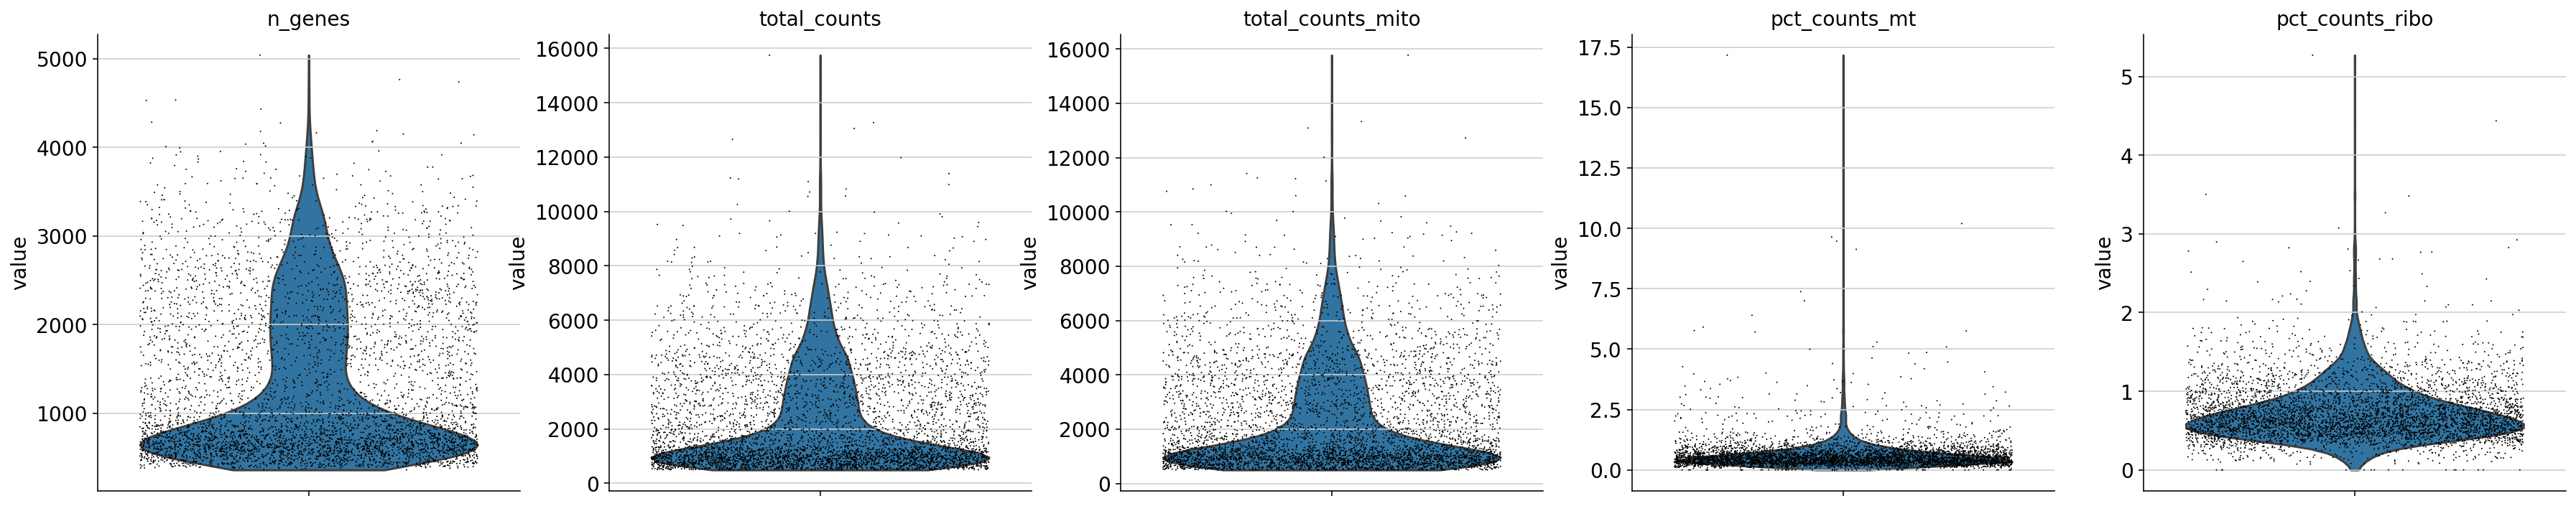

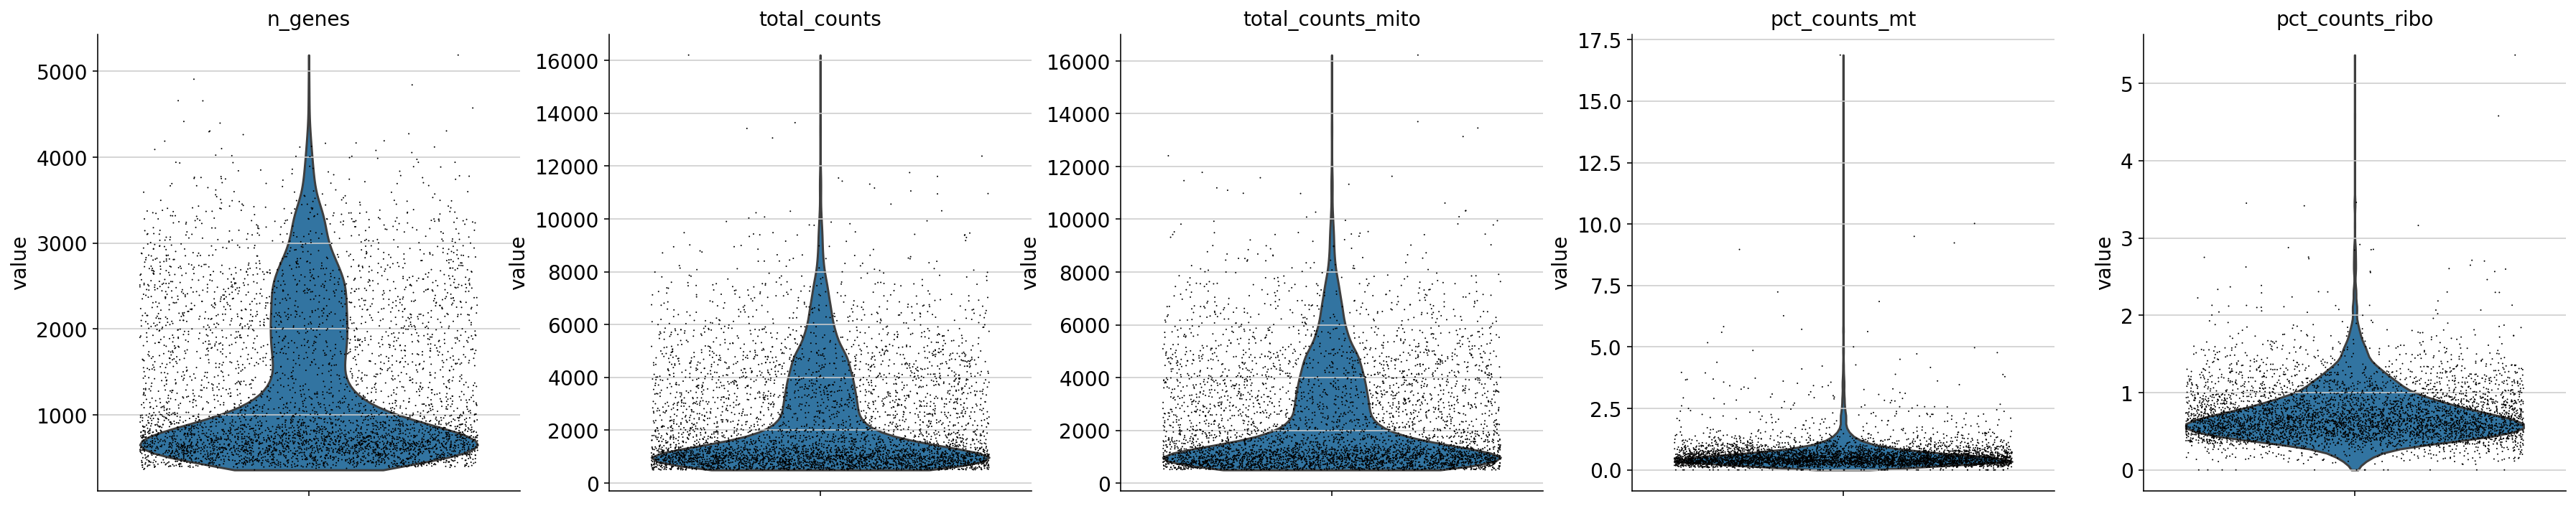

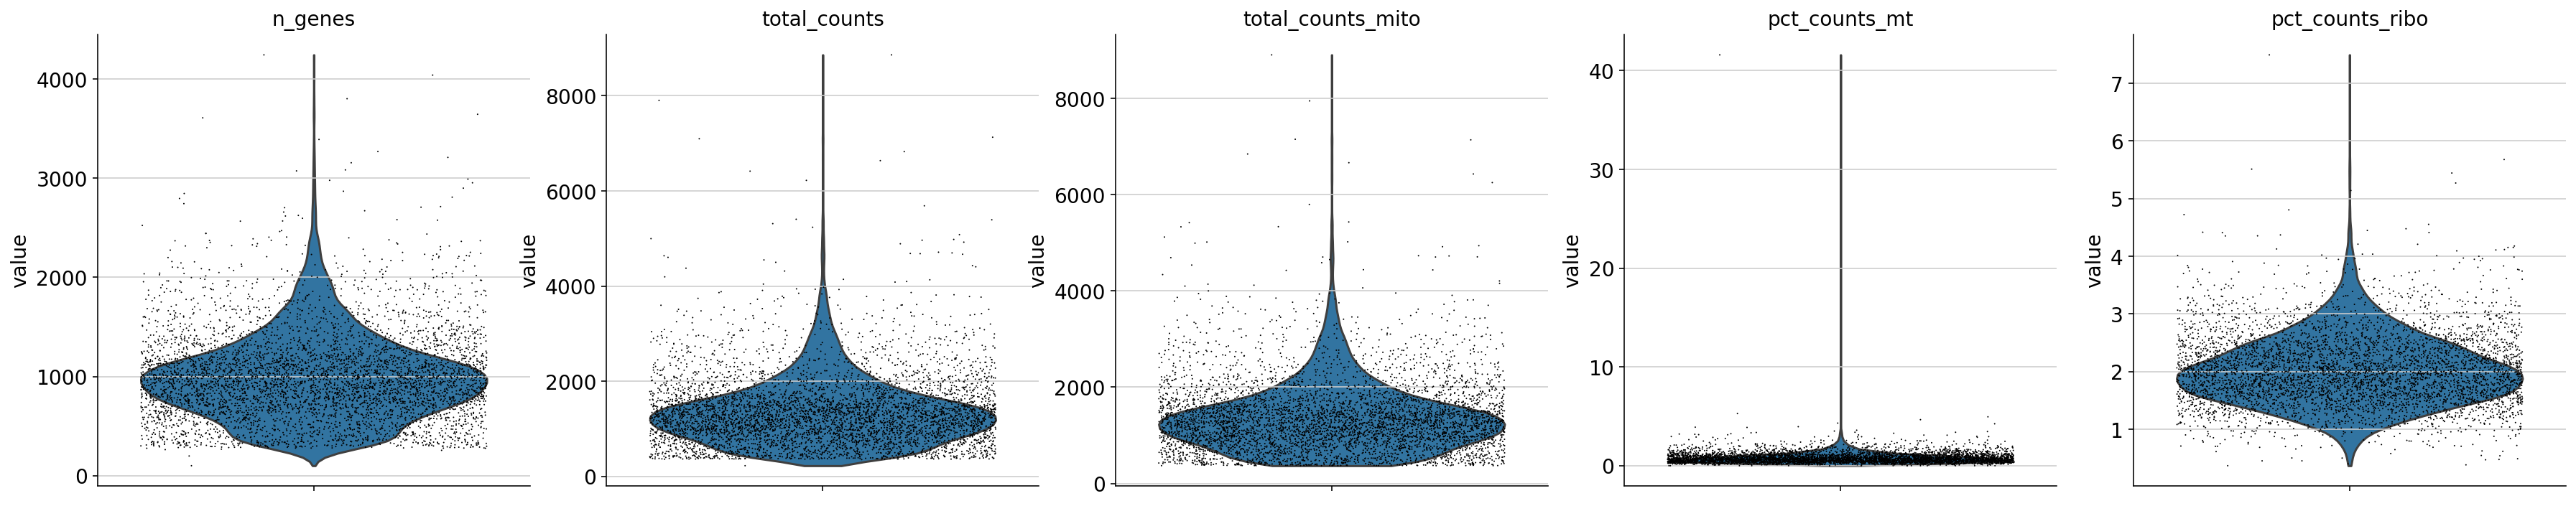

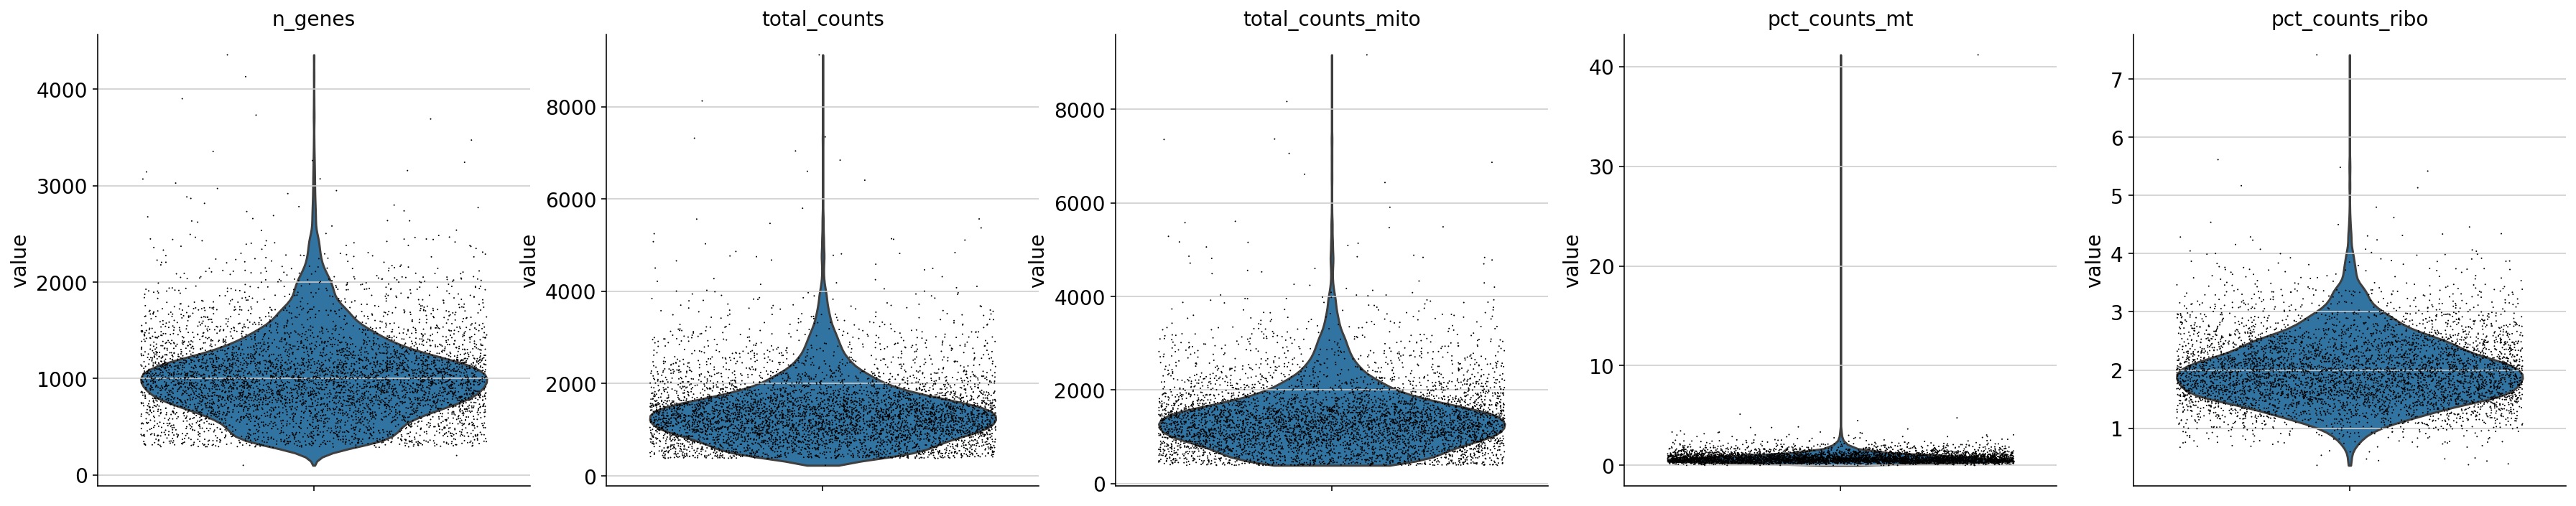

In [21]:
%matplotlib inline
for i in range(numberobj):
    sc.pl.violin(locals()[object_names[i]], ['n_genes', 'total_counts','total_counts_mito', 'pct_counts_mt','pct_counts_ribo'],
             jitter=0.4, multi_panel=True,size =1)#,save= object_names[i]+"_prefilter_all.pdf")
    plt.show()

In [22]:
print("Median numbers without mitochondrial reads\n")




for i in range(numberobj):
    median_counts = np.median(locals()[object_names[i]].obs['total_counts_mito'])
    mean_counts= int(np.mean(locals()[object_names[i]].obs['total_counts_mito']))

    median_counts_mito = np.median(locals()[object_names[i]].obs['total_counts']) 
    mean_counts_mito =int(np.mean(locals()[object_names[i]].obs['total_counts']))

    median_difference = median_counts - median_counts_mito 
    mean_difference = mean_counts -  mean_counts_mito
    
    pct_median_diff = median_difference / median_counts
    pct_mean_diff = mean_difference/mean_counts
    
    print(object_names[i],'\n',"\tmedian genes/nuclei:",np.median(locals()[object_names[i]].obs['n_genes']), '\n',
            "\tmedian reads/nuclei:",median_counts, '(',median_difference,'\t', pct_median_diff,'%',')','\n',
           "\tmean genes/nuclei:",int(np.mean(locals()[object_names[i]].obs['n_genes'])),'\n',
         "\tmean reads/nuclei:", mean_counts, '(',mean_difference,'\t', pct_mean_diff,'%',')','\n')

Median numbers without mitochondrial reads

adata_hey_93 
 	median genes/nuclei: 916.0 
 	median reads/nuclei: 1422.0 ( 11.0 	 0.0077355835 % ) 
 	mean genes/nuclei: 1312 
 	mean reads/nuclei: 2298 ( 12 	 0.005221932114882507 % ) 

adata_hey_98 
 	median genes/nuclei: 934.0 
 	median reads/nuclei: 1435.0 ( 9.0 	 0.006271777 % ) 
 	mean genes/nuclei: 1339 
 	mean reads/nuclei: 2347 ( 12 	 0.0051129100979974435 % ) 

adata_zhong_93 
 	median genes/nuclei: 948.0 
 	median reads/nuclei: 1263.5 ( 9.5 	 0.007518797 % ) 
 	mean genes/nuclei: 992 
 	mean reads/nuclei: 1373 ( 10 	 0.007283321194464676 % ) 

adata_zhong_98 
 	median genes/nuclei: 977.0 
 	median reads/nuclei: 1305.0 ( 9.0 	 0.0068965517 % ) 
 	mean genes/nuclei: 1024 
 	mean reads/nuclei: 1419 ( 10 	 0.007047216349541931 % ) 



### Save preprocessed files

In [23]:
for i in range(numberobj):
    locals()[object_names[i]].write(os.path.join('data/'+object_names[i][6:]+'_preprocessed.h5ad'))

In [24]:
!ls data/

hey_93_f1_processed_1.h5ad	zhong_93_f1_processed_1.h5ad
hey_93_f1_reg_processed_1.h5ad	zhong_93_f1_reg_processed_1.h5ad
hey_93_filtered_1.h5ad		zhong_93_filtered_1.h5ad
hey_93_preprocessed.h5ad	zhong_93_preprocessed.h5ad
hey_98_f1_processed_1.h5ad	zhong_98_f1_processed_1.h5ad
hey_98_f1_reg_processed_1.h5ad	zhong_98_f1_reg_processed_1.h5ad
hey_98_filtered_1.h5ad		zhong_98_filtered_1.h5ad
hey_98_preprocessed.h5ad	zhong_98_preprocessed.h5ad
